<a href="https://colab.research.google.com/github/naveen8801/Stackoverflow-Tag-Prediction/blob/main/StackOverflow_Tag_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer 
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import hamming_loss
from sklearn.svm import LinearSVC
import scipy as sc
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df_ques = pd.read_csv('/content/drive/MyDrive/Dataset/StackOverflow/Questions.csv',encoding="ISO-8859-1");
df_tags = pd.read_csv('/content/drive/MyDrive/Dataset/StackOverflow/Tags.csv',encoding="ISO-8859-1")

In [37]:
df_ques.info()
df_ques

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
...,...,...,...,...,...,...,...
1264211,40143210,5610777.0,2016-10-19T23:38:01Z,NaN,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...
1264212,40143300,3791161.0,2016-10-19T23:48:09Z,NaN,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...
1264213,40143340,7028647.0,2016-10-19T23:52:50Z,NaN,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...
1264214,40143360,871677.0,2016-10-19T23:55:24Z,NaN,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...


In [38]:
df_tags.info()
df_tags

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
...,...,...
3750989,40143360,javascript
3750990,40143360,vue.js
3750991,40143380,npm
3750992,40143380,mocha


In [39]:
# Combining all tags with same id under a single id
df_tags['Tag'] = df_tags['Tag'].astype(str)
group = df_tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [40]:
# Reset index of new group
group.reset_index()


,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [41]:
# Creating new tags dataframe
df_new_tags = pd.DataFrame({'Id' : group.index, 'Tag' : group.values })
df_new_tags

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [42]:
# Droping unimportant coloumns from df_ques
df_ques.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
df_ques.head()

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [43]:
# Considering only questions which are having socre greater then 5
df = df_ques[df_ques['Score']>5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      72950 non-null  int64 
 1   Score   72950 non-null  int64 
 2   Title   72950 non-null  object
 3   Body    72950 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.8+ MB


In [44]:
# Merging tags and questions in a single dataframe
df_main = df.merge(df_new_tags , on="Id")

In [45]:
# Counting nan values
df_main.isnull().sum(axis = 0)

Id       0
Score    0
Title    0
Body     0
Tag      0
dtype: int64

In [46]:
# Counting Duplicate Values
df_main.duplicated().sum(axis = 0)

0

In [47]:
# Total Unique Tags 
df_main['Tag'] = df_main['Tag'].apply(lambda tags : tags.split())
tags = [];
for tags_list in df_main['Tag']:
  for tag in tags_list:
    tags.append(tag)

tags_set = set(tags)
unique_tags = list(tags_set)
len(unique_tags)


14883

In [48]:
# Droping unimportant coloumns from df_main
df_main.drop(columns=['Id', 'Score'], inplace=True)
df_main

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
...,...,...,...
72945,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...","[python, pandas, dataframe, categorical-data]"
72946,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,"[python, iterator, nested-loops, itertools]"
72947,How can I force file ordering in F# projects u...,<p>I'm trying to work with vscode in my WebSha...,"[f#, vscode]"
72948,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


In [75]:
# Frequent Tags

keywords = nltk.FreqDist(tags)
frequencies_words = keywords.most_common(80)
tags_features = [word[0] for word in frequencies_words]
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle']

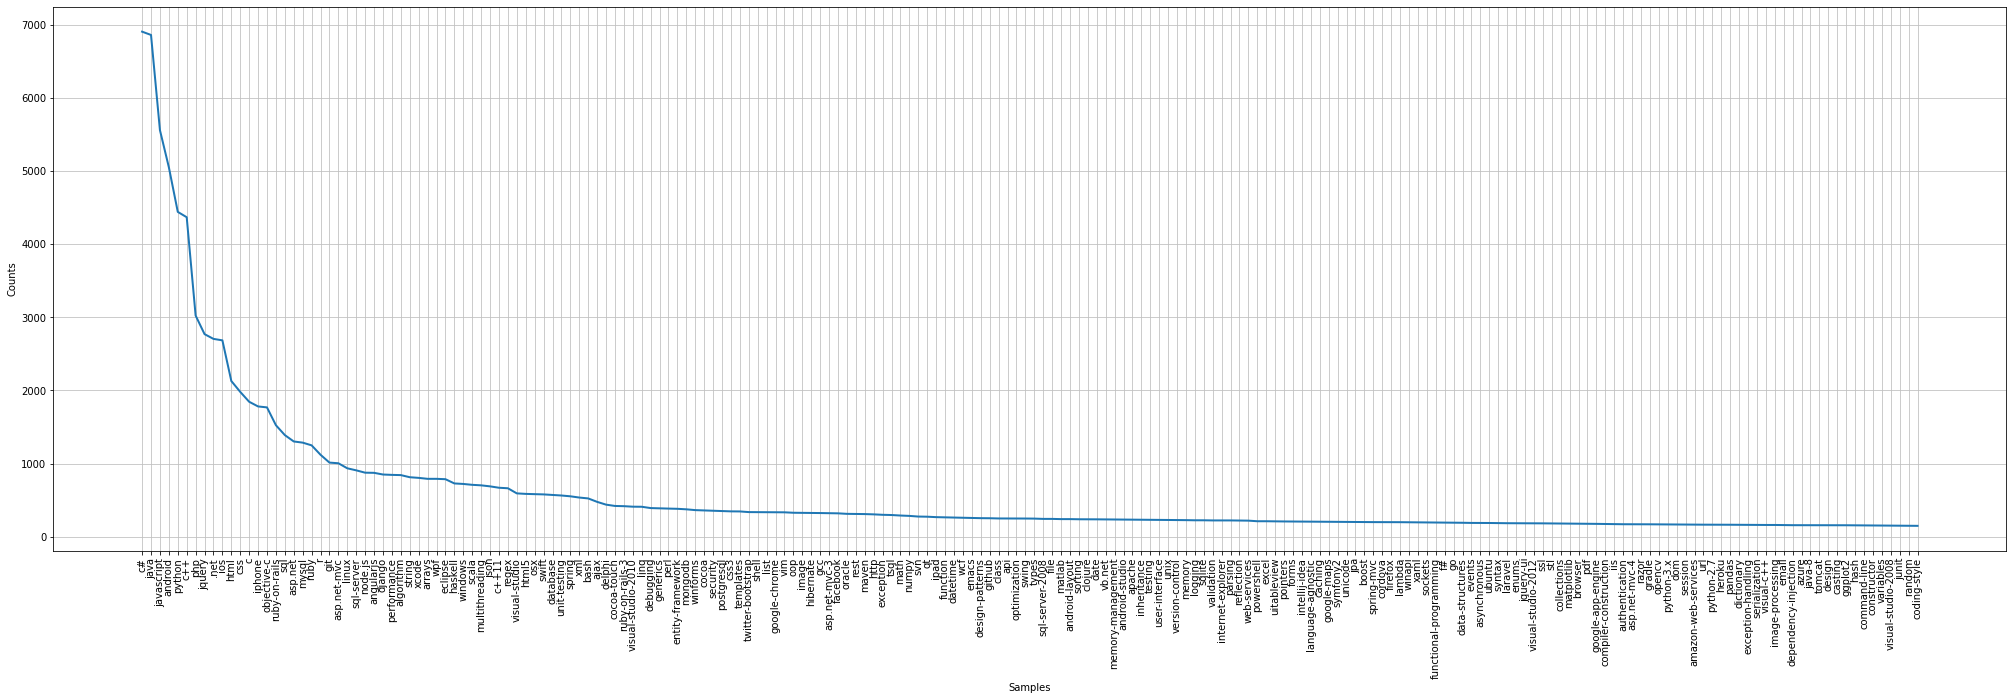

In [76]:
# Top 200 Frequent words visualisatiobn
fig, ax = plt.subplots(figsize=(35, 10))
keywords.plot(200, cumulative=False)

In [107]:
# Defining all Utilities Functions Here

# This functions will seperate tags which are among top 1000 frequent tags evaluated above (tags_features)
def MostCommonTags(tags_list):
  tag_filtered = []
  for x in tags_list:
    if x in tags_features:
      tag_filtered.append(x)
  return tag_filtered

# This funciton will clean the body coloumn text
def CleanBody(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r"\'\n", " ", text)
  text = re.sub(r"\'\xa0", " ", text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
  return text

lemma=WordNetLemmatizer()

# This function will help in lemitizing of text
def lemitizeWords(text):
    words = text.split(" ")
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))


#This function will remove all stopwords from text
def stopWordsRemove(text):
    all_stopwords = stopwords.words("english")
    words=text.split(" ")
    filtered = [w for w in words if not w in set(all_stopwords)]
    return ' '.join(map(str, filtered))

# This function will check the Jacard score of our model ( Jacard score is best option for multiclass classification )
def avg_jacard(y_true,y_pred):
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    return jacard.mean()*100

# This function will print all the scores and details of model trained
def print_score(y_test,y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")

# Prediciting my own question
def prediction(cf):
  print("Predicting your question...")
  question = "How to use ml in java and python, i have data but don't know how to use it for ml. i love machine learning as well as python and java. please help how to do ml in python and java"
  title = "ml in python and java"

  ques_ = vectorizer_X1.transform([question])
  title_ = vectorizer_X2.transform([title])

  # input = sc.sparse.hstack([ques_,title_])

  print(input)
  multilabel_binarizer.inverse_transform(cf.predict(ques_))  
  print("*******************")

In [78]:
# Keeping only tags which are among top 2000
df_main['Tag'] = df_main['Tag'].apply(lambda x : MostCommonTags(x))

# Removing those rows which as tags list as empty list 
df_main['Tag'] = df_main['Tag'].apply(lambda x : x if len(x)>0 else None)

In [79]:
# Droping nan 
df_main.dropna(subset=['Tag'], inplace=True)
df_main.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61920 entries, 2 to 72949
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   61920 non-null  object
 1   Body    61920 non-null  object
 2   Tag     61920 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [80]:
# Converting html text present in body coloumn into text
df_main['Body'] = df_main['Body'].apply(lambda x : BeautifulSoup(x).get_text())

In [81]:
# Cleaning body text
df_main['Body'] = df_main['Body'].apply(lambda x: CleanBody(x)) 

In [82]:
# Lemitization & Stopwords removal from body coloumn
df_main['Body'] = df_main['Body'].apply(lambda x: lemitizeWords(x)) 
df_main['Body'] = df_main['Body'].apply(lambda x: stopWordsRemove(x)) 

In [83]:
# Lemitization & Stopwords removal from title coloumn
df_main['Title'] = df_main['Title'].apply(lambda x: str(x)) 
df_main['Title'] = df_main['Title'].apply(lambda x: CleanBody(x)) 
df_main['Title'] = df_main['Title'].apply(lambda x: lemitizeWords(x)) 
df_main['Title'] = df_main['Title'].apply(lambda x: stopWordsRemove(x)) 

In [84]:
# TFIDF Vectorization
x1 = df_main['Body']
x2 = df_main['Title']
y = df_main['Tag']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)


vectorizer_X1 = TfidfVectorizer(analyzer = 'word',min_df=0.0,max_df = 1.0,strip_accents = None,encoding = 'utf-8', preprocessor=None,token_pattern=r"(?u)\S\S+",max_features=1000)
vectorizer_X2 = TfidfVectorizer(analyzer = 'word',min_df=0.0,max_df = 1.0,strip_accents = None,encoding = 'utf-8', preprocessor=None,token_pattern=r"(?u)\S\S+",max_features=1000)

X1_tfidf = vectorizer_X1.fit_transform(x1)
X2_tfidf = vectorizer_X2.fit_transform(x2)

X_tfidf = sc.sparse.hstack([X1_tfidf,X2_tfidf])


In [85]:
# Train Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0)

In [86]:
# Trying these four models

sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()

In [ ]:
for classifier in [sgd, lr, mn, svc]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print_score(y_test,y_pred,classifier)
    
